In [5]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
from scipy import special

params = {
    'figure.figsize': (8.5, 6.5),
    'font.style': 'normal',
    'axes.labelsize': 25,
    'font.size': 16,
    'legend.fontsize': 11,
    'xtick.labelsize': 16,
    'ytick.labelsize': 16,
    'xtick.direction': 'in',
    'ytick.direction': 'in',
    'xtick.major.size': 8,
    'ytick.major.size': 10,
    'xtick.minor.size': 4,
    'ytick.minor.size': 4,
    'xtick.major.width': 1.5,
    'ytick.major.width': 1.5,
    'font.family': 'serif',
    'legend.framealpha': 1,  # Set legend alpha to 1
    'legend.borderpad': 0.2,
    'xtick.minor.visible': True,
    'ytick.minor.visible': True
}
plt.rcParams.update(params)

from BesselML import Problem

---------------------------------- Hypergeometrical functions ----------------------------------

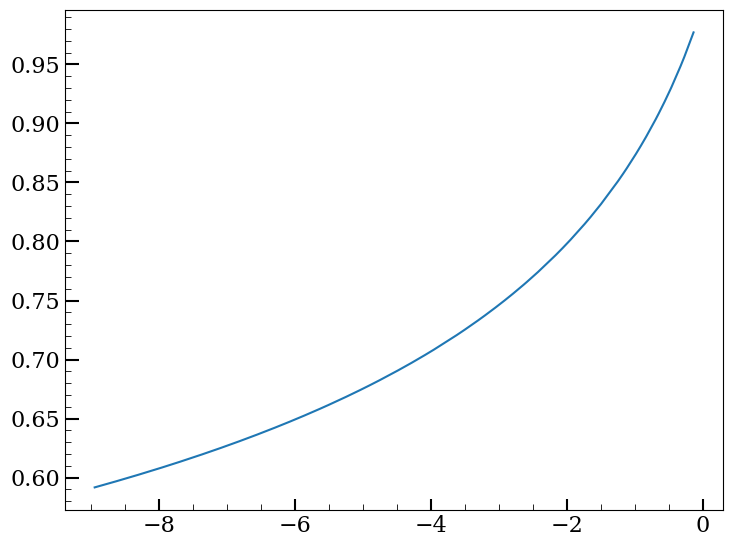

In [82]:
np.random.seed(42)
x_prime_dstrn_train = np.sort(np.random.uniform(-9.0, -0.016, 200))
x_prime_dstrn_test = np.sort(np.random.uniform(-9.0, -0.016, 200))

target_train = special.hyp2f1(1/3, 1, 11/6, x_prime_dstrn_train)
target_test = special.hyp2f1(1/3, 1, 11/6, x_prime_dstrn_test)

plt.plot(x_prime_dstrn_train, target_train)

In [83]:
# Define problem for SR optimization

hypergeom_args = {
    'allowed_symbols': "add,sub,mul,pow,aq,constant,log,variable",
    'epsilon': 1e-5,
    'objectives': ['mae', 'length'],
    'max_evaluations': int(1e16),
    'generations': int(1e16),
    'max_length': 50,
    'max_time': 60*5,
    'n_threads': 12,
}

Problem_hypergeom = Problem("Hypergeometric Function Problem", (x_prime_dstrn_train, target_train), (x_prime_dstrn_test, target_test), hypergeom_args)

In [84]:
Problem_hypergeom.solve()
print(f"number of solutions: {len(Problem_hypergeom.solutions)}")

[0.023021621629595757, 5.0], 194.45, (0.888845980167 + ((-0.203369691968) * ((-0.185387715697) * X1))), 0.00
[0.012416324578225613, 6.0], 199.12, (0.993161141872 + ((-0.113684073091) * log(((-3.327028512955) * X1)))), 0.00
[0.000833913974929601, 7.0], 202.57, (0.359000593424 + (0.644569456577 * (((-0.012597156689) * X1) ^ ((-0.051721293479) * X1)))), 0.00
[0.0007674175431020558, 8.0], 202.04, (1.063169121742 + ((-0.164444714785) * log((1.392581820488 + ((-1.824581742287) * X1))))), 0.00
[0.00028034657589159906, 9.0], 204.05, (1.189155101776 + ((-0.537813663483) * log(log((4.191188812256 + ((-1.856729865074) * X1)))))), 0.00
[4.9818158004200086e-05, 10.0], 210.24, (1.000063180923 + ((-0.145361915231) * log(((0.707106769085 ^ ((-1.731417179108) * X1)) + ((-1.856264710426) * X1))))), 0.00
[3.2087566069094464e-05, 12.0], 219.63, (1.000167369843 + ((-0.145859584212) * (log(((0.707106769085 ^ ((-1.700100183487) * X1)) + ((-1.844831466675) * X1))) / (sqrt(1 + ((-0.005449902266) * X1) ^ 2)))))

<Axes: title={'center': 'Hypergeometric Function Problem: solution 3 Train'}>

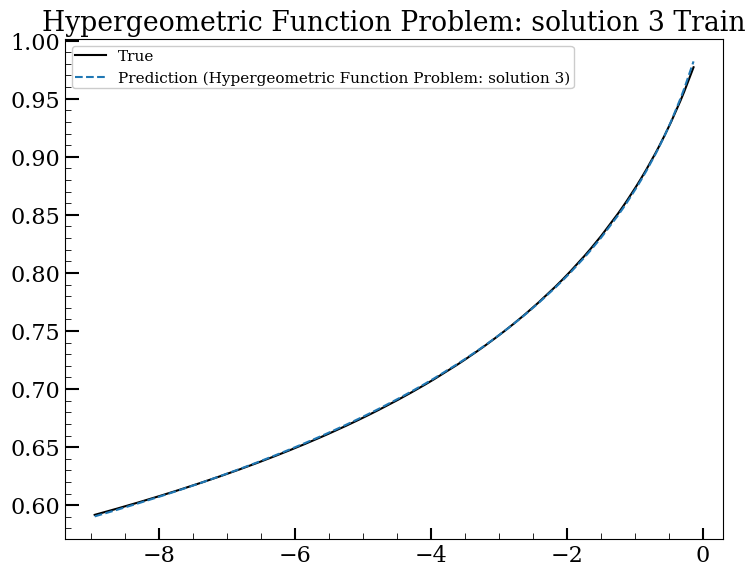

In [90]:
Problem_hypergeom.solutions[3].plot_results()

<Axes: xlabel='$-x$', ylabel='Fractional Error'>

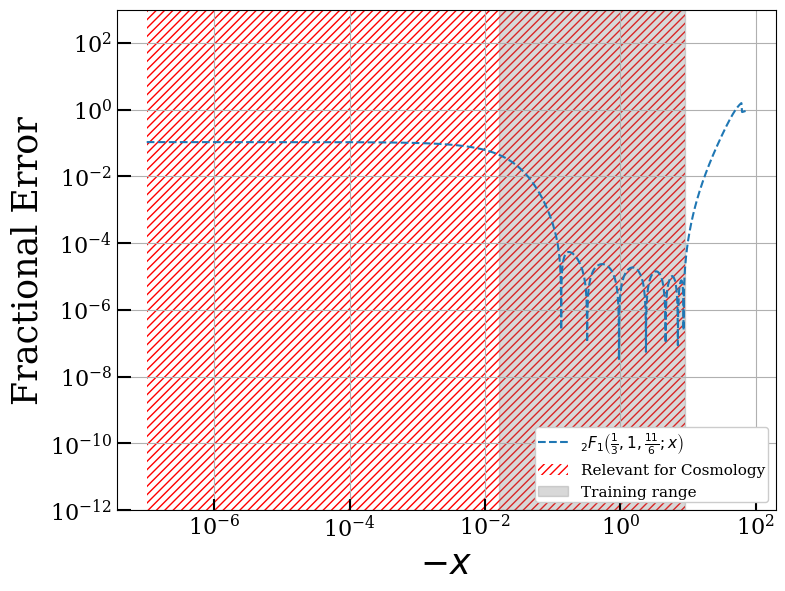

In [102]:
coeff = [1/3, 1, 11/6]  # Coefficients for the hypergeometric function for the growth factor
x_val = -1.0 * np.geomspace(10**(-7),10**7, 10000)
Problem_hypergeom.solutions[-24].plot_fractional_error_hypergeom(x_val, coeff)

#plt.savefig("/home/danielct/Pictures/oxford_internship/fractional_error_growth_factor_5min_run_sol_5.pdf", dpi=300, bbox_inches='tight')

<Axes: title={'center': 'Hypergeometric Function Problem - Length vs MSE (Pareto Front)'}, xlabel='Length', ylabel='MSE'>

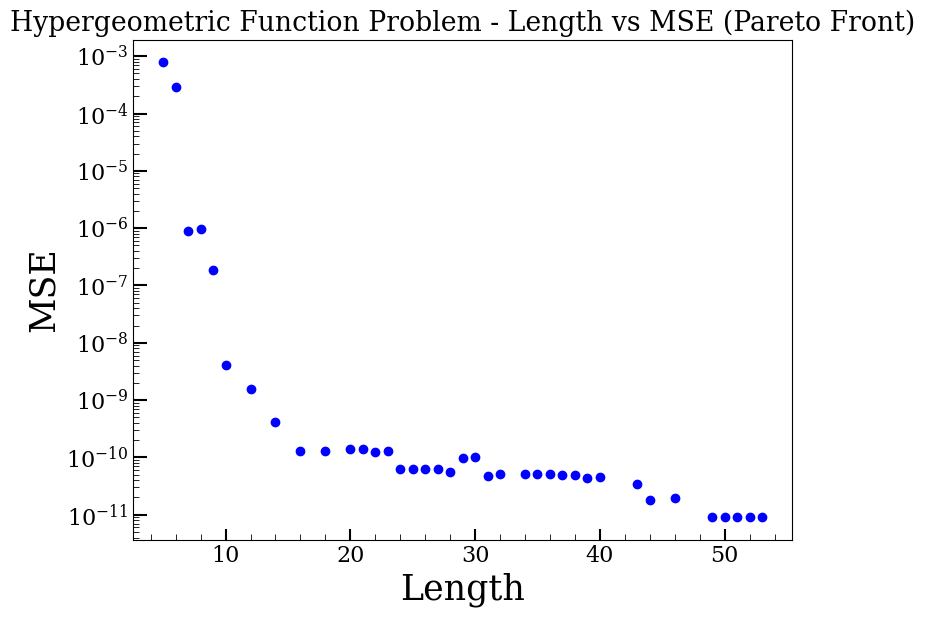

In [86]:
Problem_hypergeom.plot_l_vs_mse()

In [87]:
k=4
Problem_hypergeom.solutions[k].display_expression(), Problem_hypergeom.solutions[k].extract_and_format()

<IPython.core.display.Math object>

(None,
 ('b_{0} + b_{1}·\\log{\\left(\\log{\\left(X_{1}·b_{3} + b_{2} \\right)} \\right)}',
  {'b0': 1.189155101776,
   'b1': 0.537813663483,
   'b2': 4.191188812256,
   'b3': 1.856729865074},
  b0 + b1*log(log(X1*b3 + b2))))

In [97]:
Problem_hypergeom.export_solutions_to_latex(n=15)

LaTeX file written to latex_files/Hypergeometric_Function_Problemno_solutions_15/solutions.tex


----------- Multidimensional optimisation ----------------

In [ ]:
# Latin Hypercube Sampling Example for comoving distance (flat universe, negligible radiation), optimising based w.t.s. to redshift and omega_matter
from scipy.stats import qmc

sampler = qmc.LatinHypercube(d=2)
sample = sampler.random(n=200)

l_bound = [0, 0.1]
u_bound = [3, 0.5]

sample = qmc.scale(sample, l_bound, u_bound)
sample

In [23]:
# Generating training data for comoving distance
from scipy.integrate import quad
from typing import Tuple
c = 299792.458  # speed of light in km/s
H0 = 70.0 # Hubble constant in km/s/Mpc

def comoving_distance(params: Tuple[float, float], H0_val: float = H0) -> float:

    z, omega_m = params
    if z < 0 or not (0 < omega_m < 1):
        raise ValueError("Invalid input: z must be >= 0 and 0 < omega_m < 1")

    def inv_E(z_prime):
        return 1.0 / np.sqrt(omega_m * (1 + z_prime)**3 + (1 - omega_m))

    integral, _ = quad(inv_E, 0, z)
    D_C = (c / H0_val) * integral  # in Mpc
    return D_C

comoving_distances = np.array([comoving_distance(sample[i]) for i in range(len(sample))])


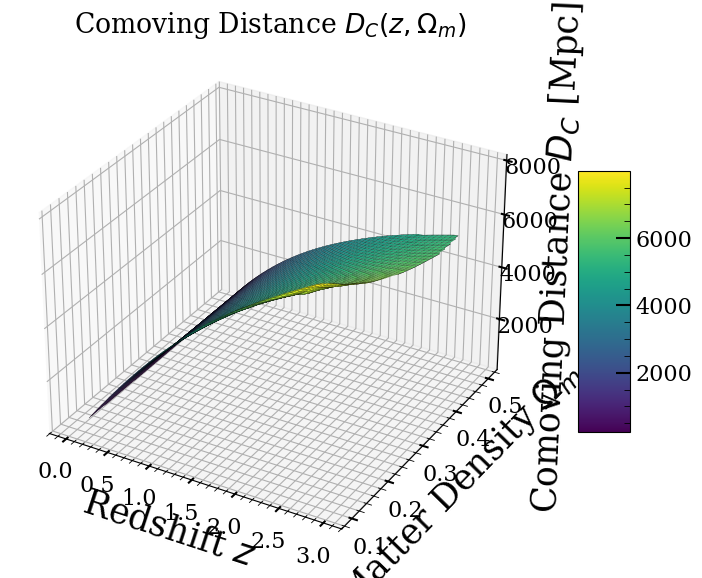

In [24]:
from scipy.interpolate import griddata

# Create grid
z_lin = np.linspace(sample[:, 0].min(), sample[:, 0].max(), 100)
omega_m_lin = np.linspace(sample[:, 1].min(), sample[:, 1].max(), 100)
Z_grid, OmegaM_grid = np.meshgrid(z_lin, omega_m_lin)

# Interpolate the scattered data onto the grid
D_C_grid = griddata(sample, comoving_distances, (Z_grid, OmegaM_grid), method='cubic')

# Plot the surface
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')

surf = ax.plot_surface(Z_grid, OmegaM_grid, D_C_grid,
                       cmap='viridis', edgecolor='k', linewidth=0.1)

ax.set_xlabel('Redshift $z$')
ax.set_ylabel('Matter Density $\\Omega_m$')
ax.set_zlabel('Comoving Distance $D_C$ [Mpc]')
ax.set_title('Comoving Distance $D_C(z, \\Omega_m)$')
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.tight_layout()
plt.show()


In [36]:
name = "comoving distance 2d problem"

d2_args = {
    'allowed_symbols': "add,sub,mul,pow,aq,constant,log,exp,variable",
    'epsilon': 1e-5,
    'objectives': ['rmse', 'length'],
    'max_evaluations': int(1e16),
    'generations': int(1e16),
    'max_length': 50,
    'max_time': 60*10,
    'n_threads': 12,
}

Problem_comoving_distance = Problem(name, (sample, comoving_distances), (sample, comoving_distances), d2_args)

In [37]:
Problem_comoving_distance.solve()

[580.2598876953125, 5.0], 33670376.00, (1001.524780273438 + ((-1889.431152343750) * ((-1.068457365036) * X1))), 336701.54
[445.9708251953125, 6.0], 19889226.00, (7775.723632812500 + ((-7766.932617187500) * exp(((-0.563742518425) * X1)))), 198889.99
[156.56808471679688, 7.0], 2451601.00, (9359.372070312500 + ((-9173.103515625000) * ((0.257703989744 * X2) ^ (0.153581678867 * X1)))), 24513.57
[151.44102478027344, 8.0], 2293687.75, (16324.224609375000 + ((-5950.573242187500) * exp(((0.257752835751 * X2) ^ (0.090901695192 * X1))))), 22934.38
[110.88817596435547, 9.0], 1229875.62, (119.124267578125 + ((-5031.539062500000) * (((-0.887870252132) * X1) / (sqrt(1 + (((-0.421143949032) * X1) + ((-1.967191100121) * X2)) ^ 2))))), 12296.19
[42.771942138671875, 10.0], 183206.48, (4175.814941406250 + ((-4228.741210937500) * ((((-0.416886359453) * X1) / (sqrt(1 + (6.164944171906 * X2) ^ 2))) + exp(((-0.887870252132) * X1))))), 1829.44
[37.628639221191406, 11.0], 141858.67, (4800.085937500000 + ((-4835

In [44]:
Problem_comoving_distance.solutions[4].display_expression()

<IPython.core.display.Math object>

In [47]:
Problem_comoving_distance.export_solutions_to_latex(n=14)

LaTeX file written to latex_files/comoving_distance_2d_problemno_solutions_14/solutions.tex


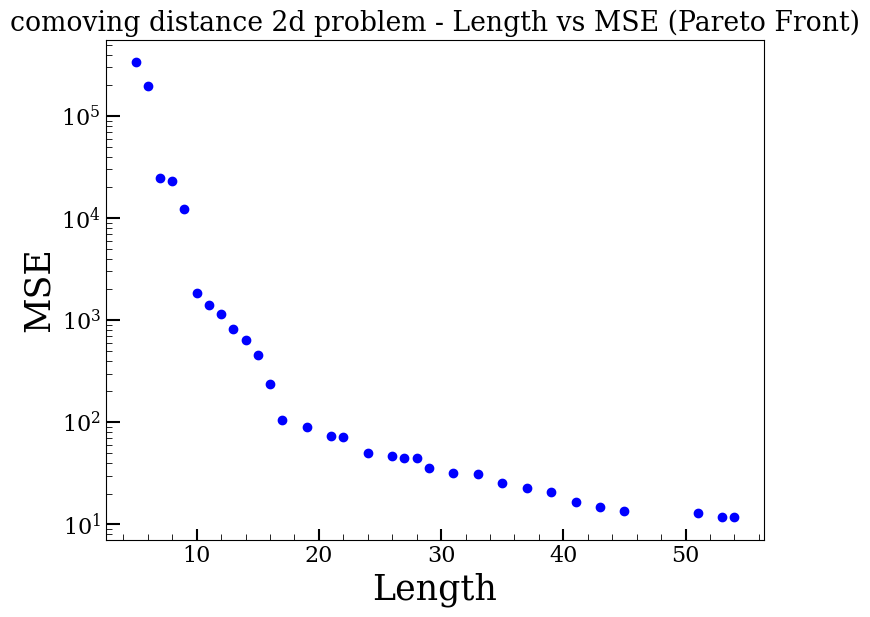

In [45]:
Problem_comoving_distance.plot_l_vs_mse()


plt.savefig("/home/danielct/Pictures/oxford_internship/comoving_distance_2d_problem.pdf", dpi=300, bbox_inches='tight')